In [ ]:
from typing import List, Annotated
from pydantic import BaseModel
from langgraph.graph import StateGraph, END
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.schema import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [7]:
llm = OpenAI(model="gpt-4o-mini")
llm

OpenAI(client=<openai.resources.completions.Completions object at 0x0000016FE8951F10>, async_client=<openai.resources.completions.AsyncCompletions object at 0x0000016FE8782C90>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [9]:
url = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

docs= []
loader = [WebBaseLoader(url) for url in url]
for loader in loader:
    docs.extend(loader.load())

In [ ]:
print(docs)

In [14]:
### Text Splitter
from langchain_community.vectorstores import Chroma
persist_directory ="./chroma_db"

spillter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap =50)
split_docs = spillter.split_documents(docs)
embedding = OpenAIEmbeddings()

vectiorstore = Chroma.from_documents(
        persist_directory=persist_directory,
        embedding=embedding,
        documents=split_docs,
        collection_name="lili_research_db"
    
    )

retriver = vectiorstore.as_retriever()

In [17]:
response = retriver.invoke("what is Tool use?")

In [31]:
for index, doc in enumerate(response):
    print(f"Page Number:{index}\n Page conte:{response[index].page_content}")


Page Number:0
 Page conte:Comparison of MIPS algorithms, measured in recall@10. (Image source: Google Blog, 2020)

Check more MIPS algorithms and performance comparison in ann-benchmarks.com.
Component Three: Tool Use#
Tool use is a remarkable and distinguishing characteristic of human beings. We create, modify and utilize external objects to do things that go beyond our physical and cognitive limits. Equipping LLMs with external tools can significantly extend the model capabilities.
Page Number:1
 Page conte:A picture of a sea otter using rock to crack open a seashell, while floating in the water. While some other animals can use tools, the complexity is not comparable with humans. (Image source: Animals using tools)
Page Number:2
 Page conte:Both TALM (Tool Augmented Language Models; Parisi et al. 2022) and Toolformer (Schick et al. 2023) fine-tune a LM to learn to use external tool APIs. The dataset is expanded based on whether a newly added API call annotation can improve the quali

In [21]:
## Creating the RAG State

class RagState(BaseModel):
    state_question :str
    state_doc : List[Document]=[]
    state_answer:str=" "



In [ ]:
### Creating Retriver node

def retrive_docs(state:RagState):
    llm_result_docs = retriver.invoke(state.state_question)
    return RagState(state_question=state.state_question,state_doc= state.state_doc)

def responder(state:RagState):
    stuff_doc ="\n".join([doc.page_content for doc in state.state_doc])
    prompt =f"Answer the question {state.state_question} based on the context.\nContext:\n{stuff_doc}"
    response=llm.invoke(prompt)
    return RagState(state_question =state.state_question,state_doc=state.state_doc, state_answer = response)



In [42]:
### Creating State Graph

graph=StateGraph(RagState)

graph.add_node("Retriver",retrive_docs)
graph.add_node("Responder", responder)

graph.set_entry_point("Retriver")
graph.add_edge("Retriver","Responder")
graph.add_edge("Responder",END)

graph_builder= graph.compile()

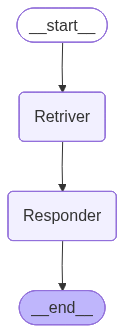

In [43]:
graph_builder

In [44]:
## Run Agentic RAG

if __name__ == "__main__":
    user_question ="What is the concept of agent loop in autonomous agents?"
    initial_state = RagState(state_question=user_question)
    final_state = graph_builder.invoke(initial_state)

    print("\n Final Answer:\n",final_state["state_answer"])
                                       


 Final Answer:
 - The agent loop refers to the continuous cycle of observation, decision-making, and action that an autonomous agent undergoes in its environment.
- It begins with the agent perceiving its surroundings through sensors, which provide input about the current state of the environment.
- The agent then processes this information, using its internal model and decision-making algorithms to formulate a response.
- Finally, the agent acts on its environment, carrying out the chosen action, which may further affect the environment and lead to new observations.
- This cycle repeats indefinitely, allowing the agent to adapt and respond to changing conditions in its environment, making it capable of autonomous behavior. 

Overall, the concept of the agent loop is crucial for understanding how autonomous agents operate and interact with their environments in a dynamic and adaptive manner.


In [45]:
final_state

{'state_question': 'What is the concept of agent loop in autonomous agents?',
 'state_doc': [],
 'state_answer': '- The agent loop refers to the continuous cycle of observation, decision-making, and action that an autonomous agent undergoes in its environment.\n- It begins with the agent perceiving its surroundings through sensors, which provide input about the current state of the environment.\n- The agent then processes this information, using its internal model and decision-making algorithms to formulate a response.\n- Finally, the agent acts on its environment, carrying out the chosen action, which may further affect the environment and lead to new observations.\n- This cycle repeats indefinitely, allowing the agent to adapt and respond to changing conditions in its environment, making it capable of autonomous behavior. \n\nOverall, the concept of the agent loop is crucial for understanding how autonomous agents operate and interact with their environments in a dynamic and adaptive